In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model

Using TensorFlow backend.


In [3]:
df = pd.read_csv("Data/TATAMOTORS.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
df.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Date.1
Date,,,,,,,,,,,,,,,
2019-11-19,TATAMOTORS,EQ,170.10,170.80,171.75,167.10,167.90,167.75,168.80,19599195,3.308411e+14,93852.0,4044634,0.2064,2019-11-19
2019-11-20,TATAMOTORS,EQ,167.75,167.75,170.20,166.20,167.30,167.40,168.21,19504078,3.280718e+14,82289.0,2804012,0.1438,2019-11-20
2019-11-21,TATAMOTORS,EQ,167.40,166.95,170.10,163.00,164.30,164.15,166.91,21609120,3.606878e+14,105085.0,3277278,0.1517,2019-11-21
2019-11-22,TATAMOTORS,EQ,164.15,164.90,165.25,160.55,162.25,162.35,162.25,21200979,3.439810e+14,104018.0,3839460,0.1811,2019-11-22
2019-11-25,TATAMOTORS,EQ,162.35,160.70,166.60,159.90,166.00,166.10,163.96,26131453,4.284384e+14,104799.0,3304961,0.1265,2019-11-25


In [4]:
columns=['Prev Close','Open', 'High', 'Low', 'Close', 'Volume', 'Turnover']

In [5]:
df_final= df[columns]
df_final.tail()

,Prev Close,Open,High,Low,Close,Volume,Turnover
Date,,,,,,,
2019-11-19,170.10,170.80,171.75,167.10,167.75,19599195,3.308411e+14
2019-11-20,167.75,167.75,170.20,166.20,167.40,19504078,3.280718e+14
2019-11-21,167.40,166.95,170.10,163.00,164.15,21609120,3.606878e+14
2019-11-22,164.15,164.90,165.25,160.55,162.35,21200979,3.439810e+14
2019-11-25,162.35,160.70,166.60,159.90,166.10,26131453,4.284384e+14


In [6]:
df_final.describe()

,Prev Close,Open,High,Low,Close,Volume,Turnover
count,2716.000000,2716.000000,2716.000000,2716.000000,2716.00000,2.716000e+03,2.716000e+03
mean,450.325994,450.748454,457.904161,443.013641,450.34525,9.563685e+06,3.114246e+14
std,273.486830,273.813728,277.752411,269.326562,273.52239,1.109077e+07,2.281021e+14
min,107.700000,108.900000,111.600000,106.000000,107.70000,1.235100e+04,3.710208e+11
25%,270.025000,270.475000,274.975000,265.700000,270.02500,4.165382e+06,1.989609e+14
50%,388.175000,387.000000,393.300000,382.000000,388.17500,6.649906e+06,2.636573e+14
75%,517.912500,518.425000,524.425000,510.787500,517.91250,1.059023e+07,3.693935e+14
max,1365.150000,1361.000000,1382.000000,1347.000000,1365.15000,1.844356e+08,5.062943e+15


In [7]:
df_final.isnull().values.any()

False

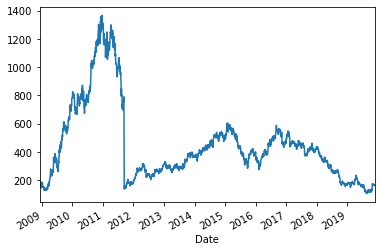

In [8]:
df_final['Close'].plot()

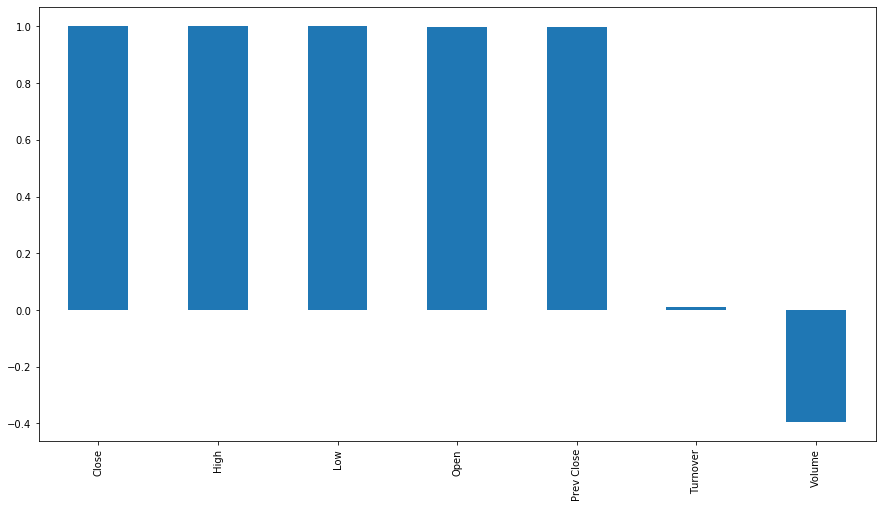

In [9]:
# Plotting Correlation of "Churn" with predictors
plt.figure(figsize=(15,8))
df_final.corr()['Close'].sort_values(ascending = False).plot(kind='bar')

In [10]:
test = df_final
# Target column
target = pd.DataFrame(test['Close'])
test.head()

,Prev Close,Open,High,Low,Close,Volume,Turnover
Date,,,,,,,
2008-12-05,150.95,152.0,159.60,149.50,153.15,2595491,4.032919e+13
2008-12-08,153.15,158.8,168.00,150.20,152.10,2134296,3.340826e+13
2008-12-10,152.10,155.2,171.75,146.00,163.45,4183216,6.489577e+13
2008-12-11,163.45,167.0,172.95,158.10,160.65,3045669,5.026006e+13
2008-12-12,160.65,155.0,155.65,146.85,153.35,2044404,3.112422e+13


In [11]:
# selecting Feature Columns
feature_columns=['Prev Close','Open', 'High', 'Low', 'Volume', 'Turnover']

In [12]:
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,Prev Close,Open,High,Low,Volume,Turnover
Date,,,,,,
2008-12-05,0.034395,0.034422,0.037783,0.035052,0.014007,0.007893
2008-12-08,0.036145,0.039853,0.044395,0.035616,0.011506,0.006526
2008-12-10,0.035310,0.036978,0.047347,0.032232,0.022616,0.012745
2008-12-11,0.044336,0.046402,0.048292,0.041982,0.016448,0.009854
2008-12-12,0.042109,0.036818,0.034674,0.032917,0.011018,0.006075


In [13]:
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target.shape)

Shape of features :  (2716, 6)
Shape of target :  (2716, 1)


In [14]:
# Shift target array because we want to predict the n + 1 day value
target = target.shift(-1)

In [15]:
# # Taking last 90 rows of data to be validation set
# validation_X = feature_minmax_transform[-90:-1]
# feature_minmax_transform = feature_minmax_transform[:-90]
# display(validation_X.tail())
# display(validation_y.tail())

In [16]:
print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target.shape)
display(target.tail())


 -----After process------ 

Shape of features :  (2716, 6)
Shape of target :  (2716, 1)


,Close
Date,
2019-11-19,167.40
2019-11-20,164.15
2019-11-21,162.35
2019-11-22,166.10
2019-11-25,NaN


In [17]:
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target[:len(train_index)].values.ravel(), target[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [18]:
X_train.shape

(2470, 6)

In [19]:
pd.DataFrame(feature_minmax_transform).tail()

,Prev Close,Open,High,Low,Volume,Turnover
Date,,,,,,
2019-11-19,0.049624,0.049437,0.047347,0.049234,0.106206,0.065277
2019-11-20,0.047755,0.047001,0.046127,0.048509,0.105690,0.064730
2019-11-21,0.047477,0.046362,0.046048,0.045931,0.117104,0.071173
2019-11-22,0.044892,0.044725,0.042231,0.043956,0.114891,0.067873
2019-11-25,0.043461,0.041370,0.043293,0.043433,0.141626,0.084555


In [20]:
pd.DataFrame(X_test).tail()

,Prev Close,Open,High,Low,Volume,Turnover
Date,,,,,,
2019-11-19,0.049624,0.049437,0.047347,0.049234,0.106206,0.065277
2019-11-20,0.047755,0.047001,0.046127,0.048509,0.105690,0.064730
2019-11-21,0.047477,0.046362,0.046048,0.045931,0.117104,0.071173
2019-11-22,0.044892,0.044725,0.042231,0.043956,0.114891,0.067873
2019-11-25,0.043461,0.041370,0.043293,0.043433,0.141626,0.084555


In [21]:
X_test.shape

(246, 6)

In [22]:
y_train.shape

(2470,)

In [23]:
y_test.shape

(246,)

In [24]:
def validate_result(model, model_name):
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print('RMSE: ', RSME_score)
    
    R2_score = r2_score(validation_y, predicted)
    print('R2 score: ', R2_score)

    plt.plot(validation_y.index, predicted,'r', label='Predict')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.ylabel('Price')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

In [25]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [27]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM

K.clear_session()

model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)


history_model_lstm = model_lstm.fit(X_tr_t, y_train, validation_data=(X_tst_t,y_test), epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Train on 2470 samples, validate on 246 samples
Epoch 1/200
2470/2470 [==============================] - 7s 3ms/step - loss: 301703.6438 - val_loss: nan
Epoch 2/200
2470/2470 [==============================] - 6s 2ms/step - loss: 296983.9475 - val_loss: nan
Epoch 3/200
2470/2470 [==============================] - 4s 2ms/step - loss: 284375.4015 - val_loss: nan
Epoch 4/200
2470/2470 [==============================] - 6s 2ms/step - loss: 265279.5100 - val_loss: nan
Epoch 5/200
2470/2470 [==============================] - 6s 2ms/step - loss: 242876.4002 - val_loss: nan
Epoch 6/200
2470/2470 [==============================] - 4s 2ms/step - loss: 219334.3550 - val_loss: nan
Epoch 7/200
2470/2470 [==============================] - 7s 3ms/step - loss: 195170.5828 - val_loss: nan
Epoch 8/200
2470/2470 [==============================] - 7s 3ms/step - loss: 171089.8976 - val_loss: nan
Epoch 9/200
2470/2470 [==============================] - 4s 2ms/step - loss: 147733.6242 - val_loss: nan
Epoch 10

2470/2470 [==============================] - 6s 2ms/step - loss: 434.8731 - val_loss: nan
Epoch 80/200
2470/2470 [==============================] - 7s 3ms/step - loss: 434.3592 - val_loss: nan
Epoch 81/200
2470/2470 [==============================] - 5s 2ms/step - loss: 434.1113 - val_loss: nan
Epoch 82/200
2470/2470 [==============================] - 7s 3ms/step - loss: 433.6428 - val_loss: nan
Epoch 83/200
2470/2470 [==============================] - 5s 2ms/step - loss: 433.2456 - val_loss: nan
Epoch 84/200
2470/2470 [==============================] - 5s 2ms/step - loss: 432.9470 - val_loss: nan
Epoch 85/200
2470/2470 [==============================] - 6s 2ms/step - loss: 432.4951 - val_loss: nan
Epoch 86/200
2470/2470 [==============================] - 5s 2ms/step - loss: 432.2764 - val_loss: nan
Epoch 87/200
2470/2470 [==============================] - 5s 2ms/step - loss: 432.0838 - val_loss: nan
Epoch 88/200
2470/2470 [==============================] - 7s 3ms/step - loss: 431.6769

2470/2470 [==============================] - 3s 1ms/step - loss: 420.9332 - val_loss: nan
Epoch 159/200
2470/2470 [==============================] - 3s 1ms/step - loss: 420.6186 - val_loss: nan
Epoch 160/200
2470/2470 [==============================] - 3s 1ms/step - loss: 420.6715 - val_loss: nan
Epoch 161/200
2470/2470 [==============================] - 5s 2ms/step - loss: 420.3435 - val_loss: nan
Epoch 162/200
2470/2470 [==============================] - 7s 3ms/step - loss: 420.3985 - val_loss: nan
Epoch 163/200
2470/2470 [==============================] - 6s 2ms/step - loss: 420.1204 - val_loss: nan
Epoch 164/200
2470/2470 [==============================] - 5s 2ms/step - loss: 420.0494 - val_loss: nan
Epoch 165/200
2470/2470 [==============================] - 6s 2ms/step - loss: 419.9592 - val_loss: nan
Epoch 166/200
2470/2470 [==============================] - 5s 2ms/step - loss: 419.9921 - val_loss: nan
Epoch 167/200
2470/2470 [==============================] - 4s 2ms/step - loss:

In [28]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test[:-1], y_pred_test_lstm[:-1])))
r2_test = r2_score(y_test[:-1], y_pred_test_lstm[:-1])

The R2 score on the Train set is:	0.994
The R2 score on the Test set is:	0.917


In [28]:
score_lstm= model_lstm.evaluate(X_tst_t[:-1], y_test[:-1], batch_size=1, verbose=0)
print('LSTM: %f'%score_lstm)

LSTM: 662.216452


In [30]:
y_pred_test_LSTM= model_lstm.predict(X_tst_t)
y_pred_test_LSTM[-1]

array([164.0074], dtype=float32)

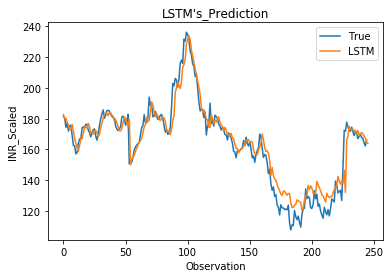

In [31]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [31]:
col1 = pd.DataFrame(y_test, columns=['True'])

col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])

col3 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3], axis=1)
results.to_excel('PredictionResults_LSTM_NonShift.xlsx')

In [37]:
# evaluate the model
train_acc = model_lstm.evaluate(X_tr_t, y_train, verbose=0)
test_acc = model_lstm.evaluate(X_tst_t[:-1], y_test[:-1], verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 1604.589, Test: 662.217


KeyError: 'val_loss'

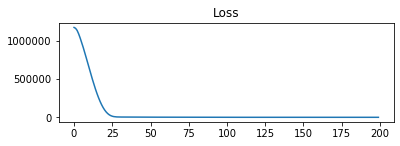

In [40]:
# plot loss during training
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history_model_lstm.history['loss'], label='train')
pyplot.plot(history_model_lstm.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history_model_lstm.history['acc'], label='train')
pyplot.plot(history_model_lstm.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

In [11]:
import numpy as np
l=np.array([[1,2]])

In [12]:
result = l.flatten() 

In [13]:
result

array([1, 2])

1